## Generative Adversarial Networks (GANs)

**Generative Adversarial Networks (GANs)** are a powerful class of generative models introduced by Ian Goodfellow in 2014. GANs are designed to **generate realistic data**, such as images, from random noise.

A GAN consists of two competing neural networks:

- **Generator (G)**: Learns to generate fake data that resemble the real data.
- **Discriminator (D)**: Learns to distinguish between real data and fake (generated) data.

The two networks play a **minimax game**:

$$
\min_G \max_D \ \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))]
$$

- $x$: a real data sample from the true distribution $p_{\text{data}}$
- $z$: a random noise vector (e.g., from $\mathcal{N}(0, I)$)
- $G(z)$: a fake data sample generated from noise
- $D(x)$: the discriminator's estimate of the probability that $x$ is real

##  Intuition

- The **generator** tries to "fool" the discriminator by generating increasingly realistic samples.
- The **discriminator** tries to become better at spotting fakes.
- Training continues until the discriminator can no longer distinguish real from fake — i.e., $D(G(z)) \approx 0.5$

#### Real-World Example: [ThisPersonDoesNotExist.com](https://thispersondoesnotexist.com)

The website [thispersondoesnotexist.com](https://thispersondoesnotexist.com) uses a **high-end GAN** (StyleGAN2 by NVIDIA) to generate ultra-realistic portraits of people who **do not exist**. Each time you refresh the page, a new human face is generated — not copied from a dataset, but imagined by the GAN.

This is a stunning example of the creative potential of GANs in the wild.


## Summary

| Component    | Role                                      |
|--------------|-------------------------------------------|
| Generator    | Maps noise $z$ to data-like outputs $G(z)$ |
| Discriminator| Distinguishes real data $x$ from fakes $G(z)$ |
| Training     | Adversarial, like a game between G and D   |

GANs have been used in **image generation**, **style transfer**, **super-resolution**, **data augmentation**, and **deepfake creation**.



### Demonstrating the Power of GANs on MNIST

In this notebook, we will explore the power of **GANs** by training a model on the **MNIST dataset**. MNIST (Modified National Institute of Standards and Technology) is a classic benchmark dataset in machine learning and computer vision.

In [58]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [59]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# -------------------------------------------
# Transform: Convert to Tensor + Normalize to [-1, 1]
# -------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                      # [0, 255] -> [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,))        # [0.0, 1.0] -> [-1.0, 1.0]
])

# -------------------------------------------
# Load MNIST dataset (train + test)
# -------------------------------------------
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# -------------------------------------------
# Create DataLoaders
# -------------------------------------------
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# -------------------------------------------
# Class names for MNIST (digits)
# -------------------------------------------
mnist_classes = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

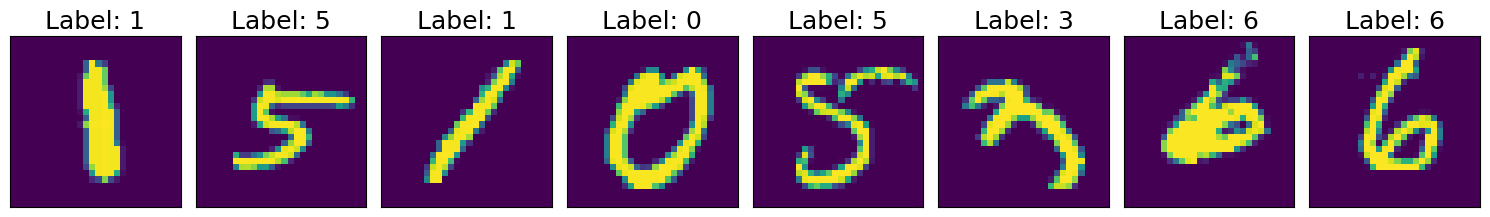

In [60]:
import matplotlib.pyplot as plt

# Get one batch
images, labels = next(iter(train_loader))

# Plot 8 images (1 rows, 8 columns)
fig, axs = plt.subplots(1, 8, figsize=(15, 4))
axs = axs.flatten()

for i in range(8):
    img = images[i].squeeze(0)  # shape: [1, 28, 28] → [28, 28]
    label = labels[i].item()
    
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {label}", fontsize=18)
    axs[i].tick_params(axis='both', labelsize=16)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

## Let's buid a simple GAN model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Basic GAN hyperparameters
batch_size = 128
latent_dim = 100           # Size of latent input z
hidden_dim = 512           # Number of neurons per layer
img_shape = (1, 28, 28)    # MNIST: 64x64 RGB images
flattened_dim = int(np.prod(img_shape))
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def dense_block(in_features, out_features, leak=0.2):
    """
    Returns a sequential block: Linear → LeakyReLU → LayerNorm
    """
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.LeakyReLU(leak),
        nn.LayerNorm(out_features)
    )

def build_simple_gan(latent_dim, hidden_dim, output_shape, leak=0.2):
    """
    Constructs a simple GAN architecture.

    Args:
        latent_dim: Dimension of the latent space (input to generator)
        hidden_dim: Number of hidden units in generator and discriminator
        output_shape: Output image shape (e.g., (1, 28, 28))
        leak: LeakyReLU negative slope
    Returns:
        G: Generator model
        D: Discriminator model
    """
    flat_output = int(np.prod(output_shape))

    # Generator: z → image
    G = nn.Sequential(
        dense_block(latent_dim, hidden_dim),
        dense_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, flat_output),
        nn.Tanh(),                         # Output in [-1, 1]
        nn.Unflatten(1, output_shape)      # Shape to (B, 1, 28, 28)
    )

    # Discriminator: image → 0/1
    D = nn.Sequential(
        nn.Flatten(),
        dense_block(flat_output, hidden_dim),
        dense_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()                       # Output probability
    )

    return G.to(device), D.to(device)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# --------------------------------------------
# 2. Build models and loss
# --------------------------------------------
G, D = build_simple_gan(latent_dim, hidden_dim, img_shape)

loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

# --------------------------------------------
# 3. Define optimizers
# --------------------------------------------
G_opt = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_opt = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# --------------------------------------------
# 4. Track losses for visualization
# --------------------------------------------
G_losses = []
D_losses = []

# --------------------------------------------
# 5. Training loop
# --------------------------------------------
for epoch in range(num_epochs):
    G.train()
    D.train()
    total_G_loss = 0.0
    total_D_loss = 0.0

    for real_imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ===============================
        # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # ===============================
        D.zero_grad()

        # Real labels (1s), Fake labels (0s)
        y_real = torch.ones(batch_size, 1, device=device)
        y_fake = torch.zeros(batch_size, 1, device=device)

        # Compute D loss on real images
        d_real_loss = loss_fn(D(real_imgs), y_real)

        # Generate fake images and detach (don't update G yet)
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = G(z).detach()  # No gradients to G
        d_fake_loss = loss_fn(D(fake_imgs), y_fake)

        # Total D loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_opt.step()

        # ===============================
        # Train Generator: maximize log(D(G(z)))
        # ===============================
        G.zero_grad()

        # Generate new batch of fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = G(z)

        # We want discriminator to believe these are real → label = 1
        g_loss = loss_fn(D(gen_imgs), y_real)

        g_loss.backward()
        G_opt.step()

        # Track losses
        total_D_loss += d_loss.item()
        total_G_loss += g_loss.item()

    avg_D_loss = total_D_loss / len(train_loader)
    avg_G_loss = total_G_loss / len(train_loader)

    D_losses.append(avg_D_loss)
    G_losses.append(avg_G_loss)

    print(f"Epoch {epoch+1:02d} | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f}")

Epoch 1/100: 100%|██████████| 938/938 [00:07<00:00, 123.72it/s]


Epoch 01 | D Loss: 0.8718 | G Loss: 1.6030


Epoch 2/100: 100%|██████████| 938/938 [00:06<00:00, 155.15it/s]


Epoch 02 | D Loss: 0.9065 | G Loss: 1.5339


Epoch 3/100: 100%|██████████| 938/938 [00:05<00:00, 165.85it/s]


Epoch 03 | D Loss: 0.9140 | G Loss: 1.5524


Epoch 4/100: 100%|██████████| 938/938 [00:05<00:00, 163.41it/s]


Epoch 04 | D Loss: 0.9081 | G Loss: 1.5701


Epoch 5/100: 100%|██████████| 938/938 [00:05<00:00, 163.76it/s]


Epoch 05 | D Loss: 0.9271 | G Loss: 1.5406


Epoch 6/100: 100%|██████████| 938/938 [00:05<00:00, 164.27it/s]


Epoch 06 | D Loss: 0.9268 | G Loss: 1.5356


Epoch 7/100: 100%|██████████| 938/938 [00:07<00:00, 127.37it/s]


Epoch 07 | D Loss: 0.9326 | G Loss: 1.5142


Epoch 8/100: 100%|██████████| 938/938 [00:05<00:00, 157.10it/s]


Epoch 08 | D Loss: 0.9291 | G Loss: 1.5061


Epoch 9/100: 100%|██████████| 938/938 [00:06<00:00, 154.83it/s]


Epoch 09 | D Loss: 0.9340 | G Loss: 1.5177


Epoch 10/100: 100%|██████████| 938/938 [00:06<00:00, 154.49it/s]


Epoch 10 | D Loss: 0.9306 | G Loss: 1.5006


Epoch 11/100: 100%|██████████| 938/938 [00:06<00:00, 146.80it/s]


Epoch 11 | D Loss: 0.9396 | G Loss: 1.4897


Epoch 12/100: 100%|██████████| 938/938 [00:08<00:00, 112.48it/s]


Epoch 12 | D Loss: 0.9381 | G Loss: 1.4908


Epoch 13/100: 100%|██████████| 938/938 [00:07<00:00, 129.85it/s]


Epoch 13 | D Loss: 0.9415 | G Loss: 1.4837


Epoch 14/100: 100%|██████████| 938/938 [00:04<00:00, 209.78it/s]


Epoch 14 | D Loss: 0.9467 | G Loss: 1.4798


Epoch 15/100: 100%|██████████| 938/938 [00:04<00:00, 224.06it/s]


Epoch 15 | D Loss: 0.9496 | G Loss: 1.4803


Epoch 16/100: 100%|██████████| 938/938 [00:04<00:00, 216.81it/s]


Epoch 16 | D Loss: 0.9543 | G Loss: 1.4707


Epoch 17/100: 100%|██████████| 938/938 [00:04<00:00, 210.09it/s]


Epoch 17 | D Loss: 0.9560 | G Loss: 1.4668


Epoch 18/100: 100%|██████████| 938/938 [00:04<00:00, 221.00it/s]


Epoch 18 | D Loss: 0.9616 | G Loss: 1.4591


Epoch 19/100: 100%|██████████| 938/938 [00:05<00:00, 172.11it/s]


Epoch 19 | D Loss: 0.9650 | G Loss: 1.4460


Epoch 20/100: 100%|██████████| 938/938 [00:04<00:00, 217.34it/s]


Epoch 20 | D Loss: 0.9710 | G Loss: 1.4384


Epoch 21/100: 100%|██████████| 938/938 [00:04<00:00, 221.69it/s]


Epoch 21 | D Loss: 0.9706 | G Loss: 1.4453


Epoch 22/100: 100%|██████████| 938/938 [00:04<00:00, 222.61it/s]


Epoch 22 | D Loss: 0.9698 | G Loss: 1.4488


Epoch 23/100: 100%|██████████| 938/938 [00:04<00:00, 225.87it/s]


Epoch 23 | D Loss: 0.9772 | G Loss: 1.4362


Epoch 24/100: 100%|██████████| 938/938 [00:04<00:00, 223.63it/s]


Epoch 24 | D Loss: 0.9851 | G Loss: 1.4322


Epoch 25/100: 100%|██████████| 938/938 [00:04<00:00, 220.92it/s]


Epoch 25 | D Loss: 0.9813 | G Loss: 1.4223


Epoch 26/100: 100%|██████████| 938/938 [00:04<00:00, 223.55it/s]


Epoch 26 | D Loss: 0.9822 | G Loss: 1.4270


Epoch 27/100: 100%|██████████| 938/938 [00:05<00:00, 164.74it/s]


Epoch 27 | D Loss: 0.9862 | G Loss: 1.4227


Epoch 28/100: 100%|██████████| 938/938 [00:04<00:00, 219.14it/s]


Epoch 28 | D Loss: 0.9844 | G Loss: 1.4192


Epoch 29/100: 100%|██████████| 938/938 [00:04<00:00, 220.32it/s]


Epoch 29 | D Loss: 0.9905 | G Loss: 1.4196


Epoch 30/100: 100%|██████████| 938/938 [00:04<00:00, 219.44it/s]


Epoch 30 | D Loss: 0.9817 | G Loss: 1.4186


Epoch 31/100: 100%|██████████| 938/938 [00:04<00:00, 218.19it/s]


Epoch 31 | D Loss: 0.9865 | G Loss: 1.4165


Epoch 32/100: 100%|██████████| 938/938 [00:04<00:00, 224.82it/s]


Epoch 32 | D Loss: 0.9829 | G Loss: 1.4249


Epoch 33/100: 100%|██████████| 938/938 [00:04<00:00, 219.29it/s]


Epoch 33 | D Loss: 0.9780 | G Loss: 1.4322


Epoch 34/100: 100%|██████████| 938/938 [00:05<00:00, 166.56it/s]


Epoch 34 | D Loss: 0.9788 | G Loss: 1.4316


Epoch 35/100: 100%|██████████| 938/938 [00:04<00:00, 220.77it/s]


Epoch 35 | D Loss: 0.9795 | G Loss: 1.4248


Epoch 36/100: 100%|██████████| 938/938 [00:04<00:00, 220.98it/s]


Epoch 36 | D Loss: 0.9753 | G Loss: 1.4318


Epoch 37/100: 100%|██████████| 938/938 [00:04<00:00, 214.69it/s]


Epoch 37 | D Loss: 0.9736 | G Loss: 1.4399


Epoch 38/100: 100%|██████████| 938/938 [00:04<00:00, 220.11it/s]


Epoch 38 | D Loss: 0.9706 | G Loss: 1.4457


Epoch 39/100: 100%|██████████| 938/938 [00:04<00:00, 219.36it/s]


Epoch 39 | D Loss: 0.9804 | G Loss: 1.4390


Epoch 40/100: 100%|██████████| 938/938 [00:04<00:00, 223.94it/s]


Epoch 40 | D Loss: 0.9724 | G Loss: 1.4429


Epoch 41/100: 100%|██████████| 938/938 [00:04<00:00, 225.18it/s]


Epoch 41 | D Loss: 0.9716 | G Loss: 1.4524


Epoch 42/100: 100%|██████████| 938/938 [00:05<00:00, 169.96it/s]


Epoch 42 | D Loss: 0.9630 | G Loss: 1.4581


Epoch 43/100: 100%|██████████| 938/938 [00:04<00:00, 226.39it/s]


Epoch 43 | D Loss: 0.9654 | G Loss: 1.4643


Epoch 44/100: 100%|██████████| 938/938 [00:04<00:00, 223.82it/s]


Epoch 44 | D Loss: 0.9626 | G Loss: 1.4671


Epoch 45/100: 100%|██████████| 938/938 [00:04<00:00, 220.58it/s]


Epoch 45 | D Loss: 0.9612 | G Loss: 1.4646


Epoch 46/100: 100%|██████████| 938/938 [00:04<00:00, 222.75it/s]


Epoch 46 | D Loss: 0.9543 | G Loss: 1.4732


Epoch 47/100: 100%|██████████| 938/938 [00:04<00:00, 223.70it/s]


Epoch 47 | D Loss: 0.9538 | G Loss: 1.4823


Epoch 48/100: 100%|██████████| 938/938 [00:04<00:00, 222.45it/s]


Epoch 48 | D Loss: 0.9561 | G Loss: 1.4861


Epoch 49/100: 100%|██████████| 938/938 [00:05<00:00, 169.00it/s]


Epoch 49 | D Loss: 0.9545 | G Loss: 1.4836


Epoch 50/100: 100%|██████████| 938/938 [00:04<00:00, 222.65it/s]


Epoch 50 | D Loss: 0.9509 | G Loss: 1.4829


Epoch 51/100: 100%|██████████| 938/938 [00:04<00:00, 221.96it/s]


Epoch 51 | D Loss: 0.9438 | G Loss: 1.4966


Epoch 52/100: 100%|██████████| 938/938 [00:04<00:00, 223.38it/s]


Epoch 52 | D Loss: 0.9409 | G Loss: 1.5115


Epoch 53/100: 100%|██████████| 938/938 [00:04<00:00, 226.98it/s]


Epoch 53 | D Loss: 0.9397 | G Loss: 1.5153


Epoch 54/100: 100%|██████████| 938/938 [00:04<00:00, 224.48it/s]


Epoch 54 | D Loss: 0.9373 | G Loss: 1.5173


Epoch 55/100: 100%|██████████| 938/938 [00:04<00:00, 226.68it/s]


Epoch 55 | D Loss: 0.9327 | G Loss: 1.5216


Epoch 56/100: 100%|██████████| 938/938 [00:04<00:00, 228.22it/s]


Epoch 56 | D Loss: 0.9284 | G Loss: 1.5226


Epoch 57/100: 100%|██████████| 938/938 [00:05<00:00, 169.25it/s]


Epoch 57 | D Loss: 0.9248 | G Loss: 1.5313


Epoch 58/100: 100%|██████████| 938/938 [00:04<00:00, 217.38it/s]


Epoch 58 | D Loss: 0.9244 | G Loss: 1.5380


Epoch 59/100: 100%|██████████| 938/938 [00:04<00:00, 218.25it/s]


Epoch 59 | D Loss: 0.9187 | G Loss: 1.5444


Epoch 60/100: 100%|██████████| 938/938 [00:04<00:00, 221.67it/s]


Epoch 60 | D Loss: 0.9171 | G Loss: 1.5527


Epoch 61/100: 100%|██████████| 938/938 [00:04<00:00, 221.76it/s]


Epoch 61 | D Loss: 0.9206 | G Loss: 1.5455


Epoch 62/100: 100%|██████████| 938/938 [00:04<00:00, 216.67it/s]


Epoch 62 | D Loss: 0.9154 | G Loss: 1.5620


Epoch 63/100: 100%|██████████| 938/938 [00:04<00:00, 221.30it/s]


Epoch 63 | D Loss: 0.9087 | G Loss: 1.5647


Epoch 64/100: 100%|██████████| 938/938 [00:04<00:00, 216.67it/s]


Epoch 64 | D Loss: 0.9083 | G Loss: 1.5768


Epoch 65/100: 100%|██████████| 938/938 [00:05<00:00, 164.97it/s]


Epoch 65 | D Loss: 0.9059 | G Loss: 1.5738


Epoch 66/100: 100%|██████████| 938/938 [00:04<00:00, 221.25it/s]


Epoch 66 | D Loss: 0.8991 | G Loss: 1.5799


Epoch 67/100: 100%|██████████| 938/938 [00:04<00:00, 217.73it/s]


Epoch 67 | D Loss: 0.8970 | G Loss: 1.5872


Epoch 68/100: 100%|██████████| 938/938 [00:04<00:00, 222.87it/s]


Epoch 68 | D Loss: 0.8951 | G Loss: 1.5896


Epoch 69/100: 100%|██████████| 938/938 [00:04<00:00, 224.18it/s]


Epoch 69 | D Loss: 0.8961 | G Loss: 1.6024


Epoch 70/100: 100%|██████████| 938/938 [00:04<00:00, 219.19it/s]


Epoch 70 | D Loss: 0.8891 | G Loss: 1.6113


Epoch 71/100: 100%|██████████| 938/938 [00:04<00:00, 222.74it/s]


Epoch 71 | D Loss: 0.8846 | G Loss: 1.6044


Epoch 72/100: 100%|██████████| 938/938 [00:05<00:00, 171.35it/s]


Epoch 72 | D Loss: 0.8859 | G Loss: 1.6199


Epoch 73/100: 100%|██████████| 938/938 [00:04<00:00, 223.97it/s]


Epoch 73 | D Loss: 0.8851 | G Loss: 1.6100


Epoch 74/100: 100%|██████████| 938/938 [00:04<00:00, 225.11it/s]


Epoch 74 | D Loss: 0.8806 | G Loss: 1.6133


Epoch 75/100: 100%|██████████| 938/938 [00:04<00:00, 220.22it/s]


Epoch 75 | D Loss: 0.8796 | G Loss: 1.6212


Epoch 76/100: 100%|██████████| 938/938 [00:04<00:00, 220.73it/s]


Epoch 76 | D Loss: 0.8749 | G Loss: 1.6296


Epoch 77/100: 100%|██████████| 938/938 [00:04<00:00, 222.18it/s]


Epoch 77 | D Loss: 0.8720 | G Loss: 1.6279


Epoch 78/100: 100%|██████████| 938/938 [00:04<00:00, 222.06it/s]


Epoch 78 | D Loss: 0.8703 | G Loss: 1.6471


Epoch 79/100: 100%|██████████| 938/938 [00:04<00:00, 223.40it/s]


Epoch 79 | D Loss: 0.8702 | G Loss: 1.6489


Epoch 80/100: 100%|██████████| 938/938 [00:05<00:00, 168.59it/s]


Epoch 80 | D Loss: 0.8619 | G Loss: 1.6610


Epoch 81/100: 100%|██████████| 938/938 [00:04<00:00, 220.31it/s]


Epoch 81 | D Loss: 0.8630 | G Loss: 1.6657


Epoch 82/100: 100%|██████████| 938/938 [00:04<00:00, 223.50it/s]


Epoch 82 | D Loss: 0.8621 | G Loss: 1.6802


Epoch 83/100: 100%|██████████| 938/938 [00:04<00:00, 220.45it/s]


Epoch 83 | D Loss: 0.8609 | G Loss: 1.6718


Epoch 84/100: 100%|██████████| 938/938 [00:04<00:00, 220.14it/s]


Epoch 84 | D Loss: 0.8522 | G Loss: 1.6822


Epoch 85/100: 100%|██████████| 938/938 [00:04<00:00, 216.56it/s]


Epoch 85 | D Loss: 0.8531 | G Loss: 1.6846


Epoch 86/100: 100%|██████████| 938/938 [00:04<00:00, 222.33it/s]


Epoch 86 | D Loss: 0.8487 | G Loss: 1.6847


Epoch 87/100: 100%|██████████| 938/938 [00:05<00:00, 167.89it/s]


Epoch 87 | D Loss: 0.8460 | G Loss: 1.6975


Epoch 88/100: 100%|██████████| 938/938 [00:04<00:00, 221.88it/s]


Epoch 88 | D Loss: 0.8468 | G Loss: 1.6921


Epoch 89/100: 100%|██████████| 938/938 [00:04<00:00, 220.97it/s]


Epoch 89 | D Loss: 0.8419 | G Loss: 1.6999


Epoch 90/100: 100%|██████████| 938/938 [00:04<00:00, 218.12it/s]


Epoch 90 | D Loss: 0.8381 | G Loss: 1.7028


Epoch 91/100: 100%|██████████| 938/938 [00:04<00:00, 223.49it/s]


Epoch 91 | D Loss: 0.8352 | G Loss: 1.7093


Epoch 92/100: 100%|██████████| 938/938 [00:04<00:00, 218.96it/s]


Epoch 92 | D Loss: 0.8350 | G Loss: 1.7105


Epoch 93/100: 100%|██████████| 938/938 [00:04<00:00, 221.77it/s]


Epoch 93 | D Loss: 0.8317 | G Loss: 1.7170


Epoch 94/100: 100%|██████████| 938/938 [00:04<00:00, 213.66it/s]


Epoch 94 | D Loss: 0.8288 | G Loss: 1.7273


Epoch 95/100: 100%|██████████| 938/938 [00:05<00:00, 168.86it/s]


Epoch 95 | D Loss: 0.8250 | G Loss: 1.7257


Epoch 96/100: 100%|██████████| 938/938 [00:04<00:00, 220.66it/s]


Epoch 96 | D Loss: 0.8249 | G Loss: 1.7419


Epoch 97/100: 100%|██████████| 938/938 [00:04<00:00, 221.07it/s]


Epoch 97 | D Loss: 0.8182 | G Loss: 1.7402


Epoch 98/100: 100%|██████████| 938/938 [00:04<00:00, 220.36it/s]


Epoch 98 | D Loss: 0.8151 | G Loss: 1.7557


Epoch 99/100: 100%|██████████| 938/938 [00:04<00:00, 220.33it/s]


Epoch 99 | D Loss: 0.8136 | G Loss: 1.7667


Epoch 100/100: 100%|██████████| 938/938 [00:04<00:00, 223.18it/s]

Epoch 100 | D Loss: 0.8171 | G Loss: 1.7537


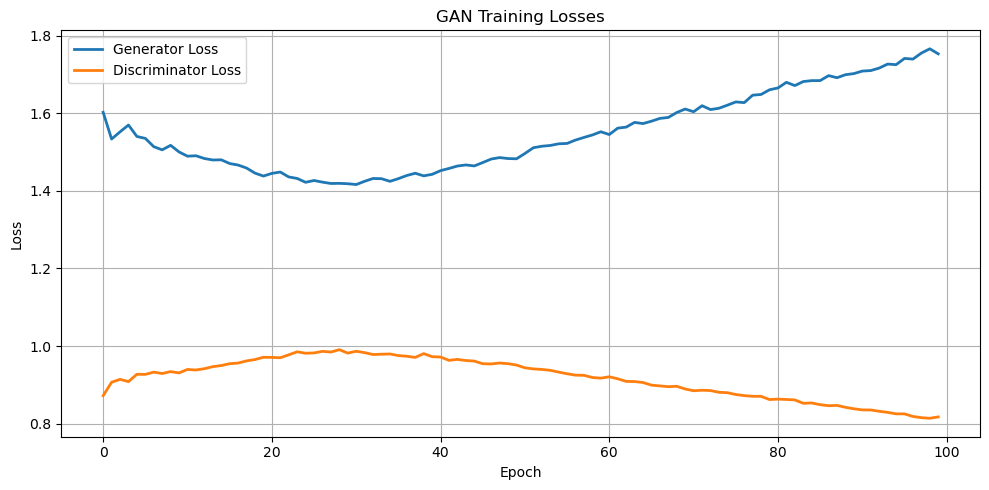

In [6]:
# Plot both losses
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss", linewidth=2)
plt.plot(D_losses, label="Discriminator Loss", linewidth=2)
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

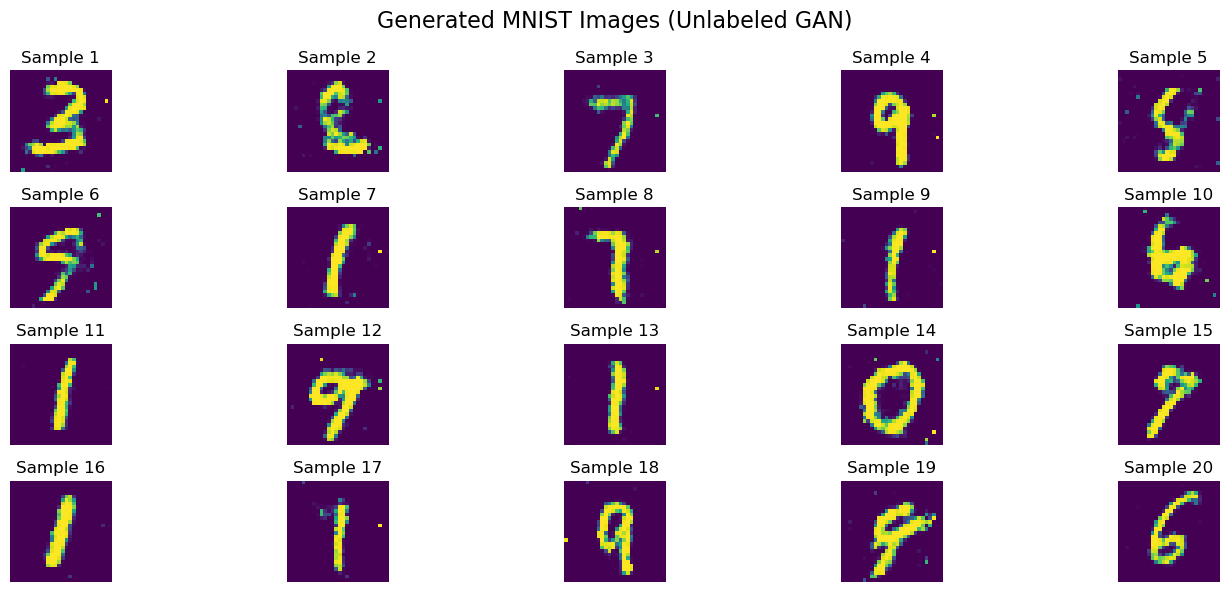

In [11]:
import matplotlib.pyplot as plt

# Set generator to eval mode
G.eval()

# Number of samples to generate
num_samples = 20
rows = 4
cols = num_samples // rows

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim, device=device)
    fake_imgs = G(z).cpu()

# Denormalize from [-1, 1] to [0, 1] for display
fake_imgs = (fake_imgs + 1) / 2

# Plotting individual images with index (since GAN is not conditional)
fig, axs = plt.subplots(rows, cols, figsize=(15, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(fake_imgs[i].squeeze())
    ax.set_title(f"Sample {i+1}")
    ax.axis("off")

plt.suptitle("Generated MNIST Images (Unlabeled GAN)", fontsize=16)
plt.tight_layout()

## **Mode Collapse** in GANs: What You're Seeing

In our GAN-generated MNIST samples, we noticed that some classes like *2* is missing entirely. This issue is a well-known phenomenon in GAN training called **mode collapse**.


### What Is Mode Collapse?

**Mode collapse** occurs when the generator learns to produce only a limited subset (or "mode") of the target distribution — ignoring the rest — because it discovers a shortcut that still fools the discriminator.

- Suppose the generator finds that generating only "shirts" consistently fools the discriminator.
- Then it may **only produce some numbers**, ignoring others.

Mathematically, instead of learning the full distribution $p_\text{data}(x)$, the generator $G(z)$ collapses to a smaller subspace:
$$
p_G(x) \approx \delta(x - x_0)
$$
where $x_0$ is a single mode (e.g., a shirt).


### Why Does This Happen?

- The generator receives no incentive to be **diverse**.
- If a few outputs successfully fool the discriminator, it may **reuse them**.
- The discriminator can become too powerful too quickly, leading to **vanishing gradients** for the generator.


### What’s Next?

In the next lecture, we will introduce **Wasserstein GANs (WGANs)** — a powerful approach to mitigating mode collapse.  
WGANs reformulate GAN training using the **Wasserstein distance**, providing:

- A smoother loss landscape,
- Better convergence,
- And significantly reduced mode collapse.


## Demonstrating Mode Collapse in GANs with Toy Gaussian Data

To visualize and understand a common failure mode of GANs—**mode collapse**—we'll use a simple toy example.

We generate a clean, structured dataset made of **9 Gaussian blobs** arranged in a 3×3 grid. Each blob represents a distinct mode in the data distribution. Ideally, a well-trained generator should learn to capture **all 9 modes**, producing samples that spread across the grid.

The image below shows the **true data distribution**—a smooth density plot from 90,000 samples (10,000 per mode), clearly showing 9 peaks. This acts as our **ground truth** for what the generator should learn.

In the next steps, we'll train a standard GAN on this toy data and observe what goes wrong. Specifically, we'll see how the generator:

- **Fails to capture all 9 modes**,
- Instead collapses to a small subset (e.g., just 1–3 blobs),
- Even though those outputs may individually look realistic.

This behavior—where the generator produces limited variety despite diverse training data—is called **mode collapse**, and it's one of the key challenges in GAN training.

**Credit**: [Edward Raff, Inside Deep Learning](https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/Chapter_9.ipynb)

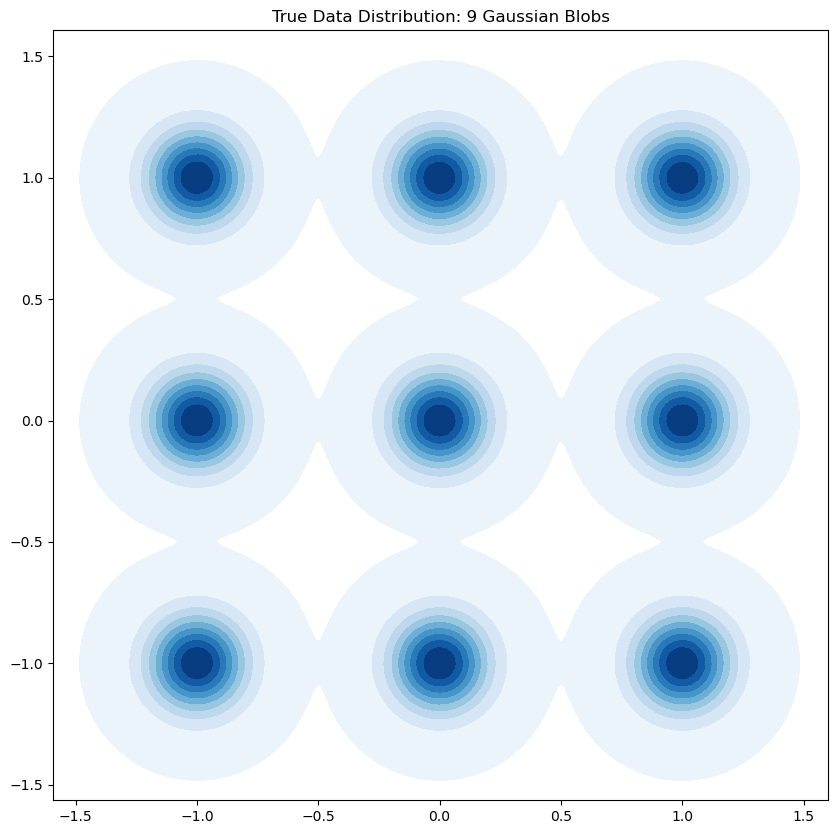

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# ----------------------------------------
# Define grid and sampling parameters
# ----------------------------------------
grid_size = (3, 3)           # 3x3 grid of Gaussians (i.e., 9 blobs)
samples_per_blob = 10_000    # Number of samples per Gaussian
blob_std = 0.05              # Spread of each Gaussian

# ----------------------------------------
# Generate samples centered at each grid location
# ----------------------------------------
X = [] #Well store all the data in here
for i in range(grid_size[0]): 
    for j in range(grid_size[1]): #these two loops go to the centers of each mean. 
        z = np.random.normal(0,blob_std, size=(samples_per_blob, 2)) #lets sample a bunch of tightly clustered points
        z[:,0] += i/1.0-(grid_size[0]-1)/2.0 #shift this random sample to have a specifix x-axis position
        z[:,1] += j/1.0-(grid_size[1]-1)/2.0 #now shift on the y-axis
        X.append(z) #collect all the samples together
X = np.vstack(X).astype(np.float32) # convert this list into one large numpy tensor of shape (N, 2)

# ----------------------------------------
# Visualize the resulting Gaussian mixture data
# ----------------------------------------
plt.figure(figsize=(10, 10))
sns.kdeplot(x=X[:, 0], y=X[:, 1], fill=True, thresh=0.001, cmap="Blues")
plt.title("True Data Distribution: 9 Gaussian Blobs")
plt.axis("equal")
plt.show()

### Training on This Simple Dataset

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ---------------------------------------------------
# 1. Generate synthetic toy dataset: 3x3 Gaussian grid
# ---------------------------------------------------
grid_size = (3, 3)           # Grid of Gaussians
samples_per_blob = 10000     # Samples per blob
blob_std = 0.05              # Spread of each Gaussian
all_samples = []

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        blob = np.random.normal(0.0, blob_std, size=(samples_per_blob, 2))
        blob[:, 0] += j / (grid_size[1] - 1)  # Shift x
        blob[:, 1] += i / (grid_size[0] - 1)  # Shift y
        all_samples.append(blob)

X = np.vstack(all_samples).astype(np.float32)
X_tensor = torch.tensor(X)

# Wrap data into PyTorch DataLoader
batch_size = 128
train_loader = DataLoader(
    TensorDataset(X_tensor),
    batch_size=batch_size,
    shuffle=True
)

# ---------------------------------------------------
# 2. Define Generator and Discriminator
# ---------------------------------------------------
latent_dim = 64     # We'll keep it 2D so we can visualize it later
hidden_dim = 128
output_dim = 2     # We want to generate (x, y) pairs
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dense_block(in_features, out_features, leak=0.2):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.LeakyReLU(leak),
        nn.LayerNorm(out_features)
    )

def build_simple_gan(latent_dim, hidden_dim, output_dim):
    G = nn.Sequential(
        dense_block(latent_dim, hidden_dim),
        dense_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, output_dim)
    )
    D = nn.Sequential(
        dense_block(output_dim, hidden_dim),
        dense_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    )
    return G.to(device), D.to(device)

G, D = build_simple_gan(latent_dim, hidden_dim, output_dim)

# ---------------------------------------------------
# 3. Loss and optimizers
# ---------------------------------------------------
loss_fn = nn.BCELoss()
G_opt = optim.Adam(G.parameters(), lr=1e-4, betas=(0.0, 0.9))
D_opt = optim.Adam(D.parameters(), lr=1e-4, betas=(0.0, 0.9))

# ---------------------------------------------------
# 4. Training loop
# ---------------------------------------------------
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    G.train()
    D.train()
    total_G_loss = 0.0
    total_D_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        real_data = batch[0].to(device)
        batch_size = real_data.size(0)

        # ----------------------------
        # Train Discriminator
        # ----------------------------
        D.zero_grad()
        y_real = torch.ones(batch_size, 1, device=device)
        y_fake = torch.zeros(batch_size, 1, device=device)

        # Discriminator loss on real data
        d_real_loss = loss_fn(D(real_data), y_real)

        # Discriminator loss on fake data
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = G(z).detach()
        d_fake_loss = loss_fn(D(fake_data), y_fake)

        # Combine and update
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_opt.step()

        # ----------------------------
        # Train Generator
        # ----------------------------
        G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_data = G(z)
        g_loss = loss_fn(D(gen_data), y_real)  # Generator wants D to think fake is real
        g_loss.backward()
        G_opt.step()

        total_D_loss += d_loss.item()
        total_G_loss += g_loss.item()

    avg_D_loss = total_D_loss / len(train_loader)
    avg_G_loss = total_G_loss / len(train_loader)
    D_losses.append(avg_D_loss)
    G_losses.append(avg_G_loss)

    print(f"Epoch {epoch+1:02d} | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f}")


Epoch 1/10: 100%|██████████| 704/704 [00:02<00:00, 250.60it/s]


Epoch 01 | D Loss: 1.2904 | G Loss: 0.7732


Epoch 2/10: 100%|██████████| 704/704 [00:03<00:00, 234.55it/s]


Epoch 02 | D Loss: 1.1637 | G Loss: 0.8999


Epoch 3/10: 100%|██████████| 704/704 [00:03<00:00, 226.74it/s]


Epoch 03 | D Loss: 1.1170 | G Loss: 0.9698


Epoch 4/10: 100%|██████████| 704/704 [00:03<00:00, 211.41it/s]


Epoch 04 | D Loss: 1.0883 | G Loss: 1.0130


Epoch 5/10: 100%|██████████| 704/704 [00:03<00:00, 215.08it/s]


Epoch 05 | D Loss: 1.0703 | G Loss: 1.0545


Epoch 6/10: 100%|██████████| 704/704 [00:03<00:00, 226.73it/s]


Epoch 06 | D Loss: 1.0502 | G Loss: 1.1031


Epoch 7/10: 100%|██████████| 704/704 [00:03<00:00, 227.01it/s]


Epoch 07 | D Loss: 1.0433 | G Loss: 1.1417


Epoch 8/10: 100%|██████████| 704/704 [00:03<00:00, 227.58it/s]


Epoch 08 | D Loss: 1.0439 | G Loss: 1.1614


Epoch 9/10: 100%|██████████| 704/704 [00:02<00:00, 236.01it/s]


Epoch 09 | D Loss: 1.0517 | G Loss: 1.1686


Epoch 10/10: 100%|██████████| 704/704 [00:04<00:00, 167.34it/s]

Epoch 10 | D Loss: 1.0711 | G Loss: 1.1579


## Visualizing GAN Output and Mode Collapse

After training the GAN on our simple 2D dataset of Gaussian blobs arranged in a 3×3 grid, we now visualize the samples generated by the Generator $ G $.

We sample latent vectors $\mathbf{z} \sim \mathcal{N}(0, I) $ and feed them to the generator $ G(\mathbf{z}) $ to obtain fake data points. These samples are plotted using a kernel density estimate (KDE) plot.

Despite the real data being spread across **9 distinct modes**, the Generator has learned to output samples that cluster only around **2 modes**. This is a classic example of **mode collapse**, a common failure mode in GANs where the generator collapses to producing a limited variety of outputs that fool the discriminator well enough.

This demonstrates that even though the discriminator loss may be low, the generator may be learning a biased and incomplete distribution of the true data.

In the next steps, we will explore how to mitigate mode collapse using **Wasserstein GAN (WGAN)**:

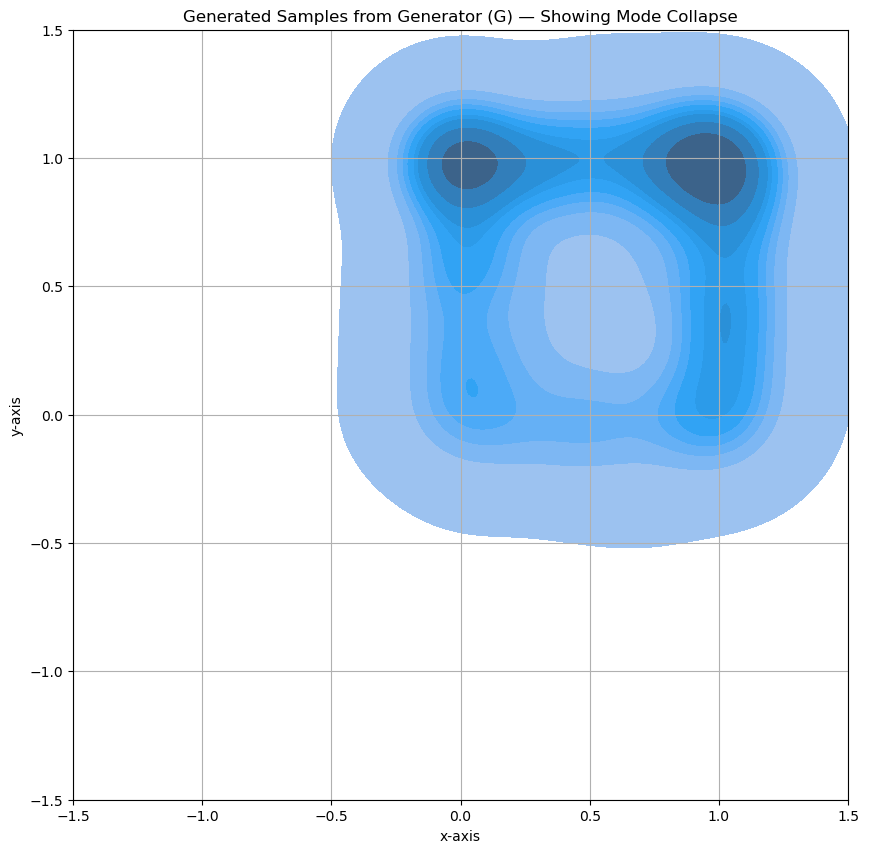

In [21]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Generate fake samples using the trained generator
with torch.no_grad():
    noise = torch.randn(1000, latent_dim, device=device)      # Sample from N(0, I)
    fake_samples = G(noise).cpu().numpy()                     # Generate fake data

# Plot the learned distribution
plt.figure(figsize=(10, 10))
sns.kdeplot(
    x=fake_samples[:, 0],
    y=fake_samples[:, 1],
    fill=True,
    thresh=0.001
)

# Set axis limits to match the original data range
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title("Generated Samples from Generator (G) — Showing Mode Collapse")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid(True)

## Let's train a Wasserstein GAN (WGAN)

### Gradient Penalty in WGAN-GP

To enforce the **Lipschitz constraint** (i.e., make sure the discriminator is 1-Lipschitz), the original WGAN used **weight clipping**, which often leads to poor performance or capacity underuse. Instead, WGAN-GP (Gulrajani et al., 2017) proposes a **soft constraint** using the **gradient norm**:

$$
\mathcal{L}_{\text{GP}} = \lambda \cdot \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} \left[ (\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2 \right]
$$

This penalty is applied to points $\hat{x}$ interpolated between real and fake data.

### How it's implemented (with `torch.autograd.grad`)
```python
# 1. Interpolate between real and fake data
eps = torch.rand(batch_size, 1, device=device)  # Uniform(0, 1)
eps = eps.expand_as(real)                       # Match shape
interpolated = eps * real + (1 - eps) * fake
interpolated.requires_grad_(True)

# 2. Compute D(interpolated)
D_interpolated = D(interpolated)

# 3. Compute gradients w.r.t. inputs
grad = torch.autograd.grad(
    outputs=D_interpolated,
    inputs=interpolated,
    grad_outputs=torch.ones_like(D_interpolated),
    create_graph=True,
    retain_graph=True,
    only_inputs=True
)[0]  # Resulting shape: [B, dim]

# 4. Compute gradient norm and penalty
grad_norm = grad.norm(2, dim=1)                 # L2 norm per sample
gradient_penalty = ((grad_norm - 1) ** 2).mean()
```

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# ---------------------------------------------------
# 1. Generate synthetic toy dataset: 3x3 Gaussian grid
# ---------------------------------------------------
grid_size = (3, 3)           # Grid of Gaussians
samples_per_blob = 10000     # Samples per blob
blob_std = 0.05              # Spread of each Gaussian

X = [] #Well store all the data in here
for i in range(grid_size[0]): 
    for j in range(grid_size[1]): #these two loops go to the centers of each mean. 
        z = np.random.normal(0,blob_std, size=(samples_per_blob, 2)) #lets sample a bunch of tightly clustered points
        z[:,0] += i/1.0-(grid_size[0]-1)/2.0 #shift this random sample to have a specifix x-axis position
        z[:,1] += j/1.0-(grid_size[1]-1)/2.0 #now shift on the y-axis
        X.append(z) #collect all the samples together
X = np.vstack(X).astype(np.float32) #convert this list into one large numpy tensor of shape (N, 2)
# Wrap data into PyTorch DataLoader
batch_size = 128
gaus_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32))
train_loader = DataLoader(gaus_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# ---------------------------------------------------
# 2. Define Generator and Discriminator
# ---------------------------------------------------
latent_dim = 64     # We'll keep it 2D so we can visualize it later
hidden_dim = 512
output_dim = (-1,2)     # We want to generate (x, y) pairs
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dense_block(in_features, out_features, leak=0.2):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.LeakyReLU(leak),
        nn.LayerNorm(out_features)
    )

class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape
    def forward(self, input):
        return input.view(*self.shape) 

def build_simple_gan(latent_d, neurons, out_shape, sigmoidG=False, leak=0.2):
    """
    This function will create a simple GAN for us to train. It will return a 
    tuple (G, D), holding the generator and discriminator network respectively. 
    
    latent_d: the number of latent variables we will use as input to the generator G. 
    neurons: how many hidden neurons to use in each hidden layer
    out_shape: the shape of the output of the discriminator D. This should be the 
    same shape as the real data. 
    sigmoidG: true if the generator G should end with a sigmoid activation, or 
    False if it should just return unbounded activations
    """
    G = nn.Sequential(
        dense_block(latent_d, neurons, leak),
        dense_block(neurons, neurons, leak),
        dense_block(neurons, neurons, leak),
        nn.Linear(neurons, abs(np.prod(out_shape)) ),# np.prod will multiply each value together in the shape, giving us the total number of needed outputs. abs will remove the impact of "-1" for the batch dimension.
        View(out_shape) # Now re-shape the output to whatever D expects. 
    )
    #Sometimes we do/don't want G to return a sigmoid value (i.e., [0,1]), so we wrap it in an a conditional
    if sigmoidG:
        G = nn.Sequential(G, nn.Sigmoid())
    
    D = nn.Sequential(
        nn.Flatten(),
        dense_block(abs(np.prod(out_shape)), neurons, leak),
        dense_block(neurons, neurons, leak),
        dense_block(neurons, neurons, leak),
        nn.Linear(neurons, 1 ) #D has 1 output for a binary classification problem
    )
    return G, D

G, D = build_simple_gan(latent_dim, hidden_dim, output_dim)


def train_wgan(D, G, loader, latent_d, epochs=20, d_updates=1, device="cpu"):
    G_losses = []
    D_losses = []

    # Move models to the specified device
    G.to(device)
    D.to(device)

    # Setup AdamW optimizers for Discriminator and Generator
    optimizerD = torch.optim.AdamW(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
    optimizerG = torch.optim.AdamW(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

    for epoch in tqdm(range(epochs)):
        for count, data in enumerate(tqdm(loader, leave=False)):

            # Unpack data if it contains labels or comes in a list
            if isinstance(data, tuple) or len(data) == 2:
                data, class_label = data
            elif isinstance(data, list) and len(data) == 1:
                data = data[0]

            batch_size = data.size(0)
            real = data.to(device)

            D.zero_grad()
            G.zero_grad()

            # -------------------------------
            # Step 1: Update Discriminator
            # -------------------------------

            # Discriminator output on real data
            D_success = D(real)

            # Generate fake data
            noise = torch.randn(batch_size, latent_d, device=device)
            fake = G(noise)

            # Discriminator output on fake data
            D_failure = D(fake)

            # Gradient penalty
            eps_shape = [batch_size] + [1] * (len(data.shape) - 1)
            eps = torch.rand(eps_shape, device=device)
            fake = eps * real + (1 - eps) * fake
            output = D(fake)

            # Compute gradients of D(fake) w.r.t. fake
            grad = torch.autograd.grad(
                outputs=output,
                inputs=fake,
                grad_outputs=torch.ones(output.size(), device=device),
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
                allow_unused=True
            )[0]

            # Compute gradient penalty term
            D_grad_penalty = ((grad.norm(2, dim=1) - 1) ** 2).mean()

            # Full discriminator loss: Wasserstein + gradient penalty
            errD = (D_failure - D_success).mean() + D_grad_penalty * 10 # TODO: change this
            errD.backward()
            optimizerD.step()

            D_losses.append(errD.item())

            # Skip generator update if not the right step
            if count % d_updates != d_updates - 1:
                continue

            # -------------------------------
            # Step 2: Update Generator
            # -------------------------------

            D.zero_grad()
            G.zero_grad()

            # Generate new fake data
            noise = torch.randn(batch_size, latent_d, device=device)
            output = -D(G(noise))

            # Generator loss: aim to maximize D(G(z)) → minimize -D(G(z))
            errG = output.mean()
            errG.backward()
            optimizerG.step()

            G_losses.append(errG.item())

    return D_losses, G_losses



# ---------------------------------------------------
# 3. Train The WGAN
# ---------------------------------------------------
D_losses, G_losses = train_wgan(D, G, train_loader, latent_dim, epochs=num_epochs, device=device)

100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


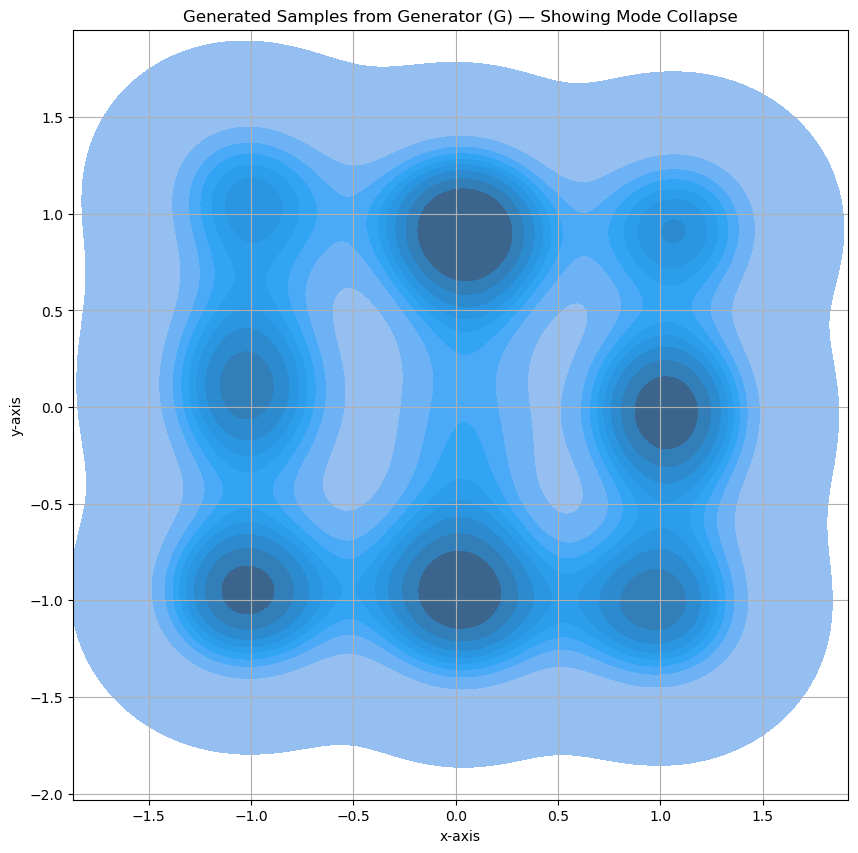

In [43]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Generate fake samples using the trained generator
with torch.no_grad():
    noise = torch.randn(1000, latent_dim, device=device)      # Sample from N(0, I)
    fake_samples = G(noise).cpu().numpy()                     # Generate fake data

# Plot the learned distribution
plt.figure(figsize=(10, 10))
sns.kdeplot(
    x=fake_samples[:, 0],
    y=fake_samples[:, 1],
    fill=True,
    thresh=0.001
)

# Set axis limits to match the original data range
#plt.xlim(-1.5, 1.5)
#plt.ylim(-1.5, 1.5)
plt.title("Generated Samples from Generator (G) — Showing Mode Collapse")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid(True)

### Generation of Air-Shower Footprints Using WGAN

When a **high-energy cosmic ray** (typically a proton or nucleus from space) enters Earth's atmosphere, it interacts with atmospheric nuclei and initiates a **cascade of secondary particles**. This cascade is called an **extensive air shower (EAS)**.

These secondary particles (such as pions, muons, electrons, and photons) spread out and travel toward the ground. When they hit an array of detectors, they produce a spatial pattern called an **air-shower footprint**.

This footprint:

- Tells us **which detectors were triggered**.
- Shows **stronger signals closer to the shower core**.
- Helps reconstruct the **energy and direction** of the primary cosmic ray.

Training a **Wasserstein GAN (WGAN)** to generate realistic 9×9 air-shower footprints allows us to:
- Simulate rare events for **data augmentation**.
- **Benchmark detectors** or classification pipelines.
- Study the **statistical properties** of EAS without relying only on Monte Carlo simulations.

#### Air Shower Formation Diagram

Below is a schematic of an air shower, where a **primary cosmic ray** creates cascades of:

- Electrons/positrons (e⁻/e⁺),
- Muons (μ),
- Neutrinos (ν),
- Pions (π),
- Photons (γ),
- and hadrons (N).

This results in a rich and detectable particle footprint on the surface:

![Air Shower Formation](./CosmicRays.png)

### Air Shower Dataset

To train the WGAN model, we use a dataset of simulated **cosmic-ray air shower footprints**. These simulations were generated using methods described in [this paper](https://doi.org/10.1016/j.astropartphys.2017.10.006).

Each sample in the dataset represents a **2D grid (e.g., 9×9)** corresponding to a surface detector array. The values in this grid indicate the **intensity of particle signals** detected at each station, giving a spatial footprint of a single air shower.

We download and load the data using:
**Credit**: [Deep Learning for Physics Reasearch](https://github.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/Exercise_18_2_solution.ipynb)

In [45]:
import gdown
import numpy as np

# Download the data
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1JfuYem6sXQSE3SYecHnNk5drtC7YKoYz"
output = 'airshowers.npz'
gdown.download(url, output, quiet=True)

# Load the NPZ file
file = np.load(output)
shower_maps = file['shower_maps']
nsamples = len(shower_maps)

###  Visualizing Random Air Shower Footprints

After loading the dataset, we visualize a few **randomly selected air-shower footprints** from the `shower_maps` array. Each footprint is a 9×9 grid showing signal intensities at different detector stations.

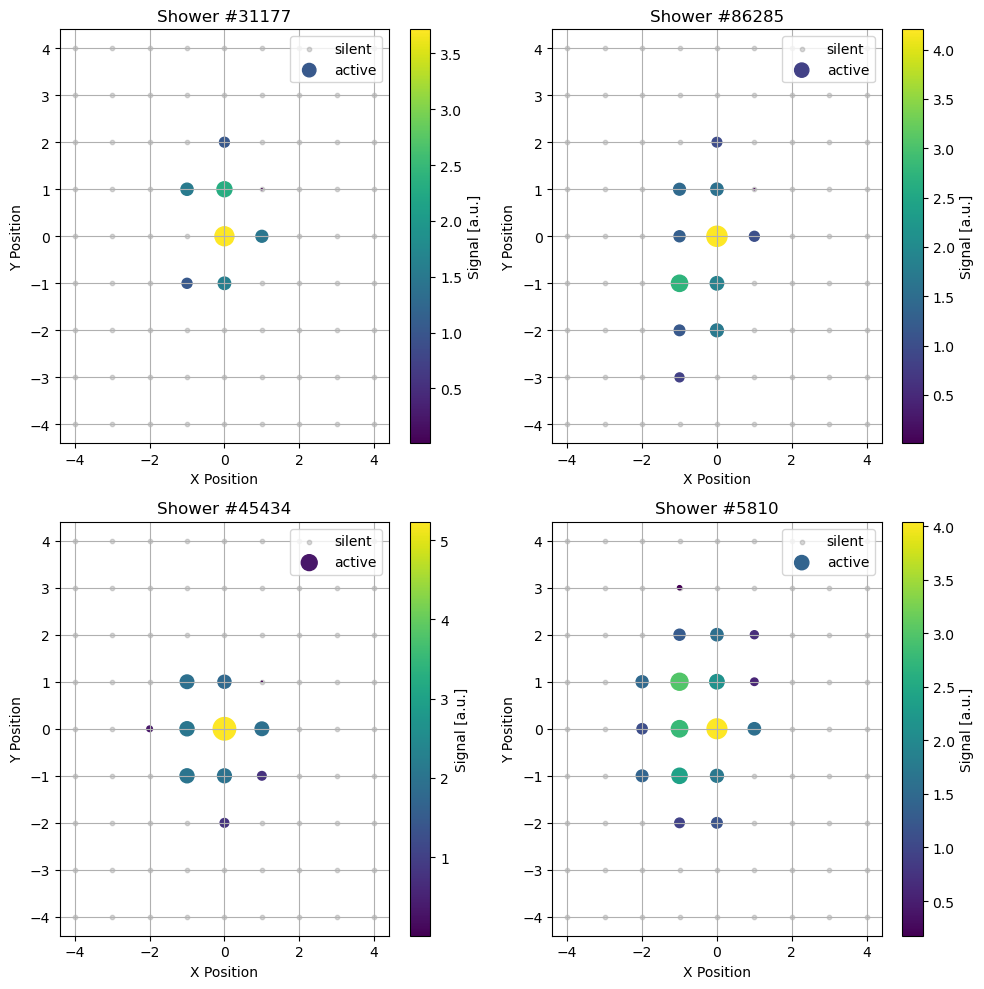

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def rectangular_array(n=9):
    """
    Generate x and y coordinates for an n x n rectangular detector grid.
    The grid is centered around (0, 0).
    
    Parameters:
        n (int): Grid dimension (n x n stations)
    
    Returns:
        (ndarray, ndarray): X and Y coordinates of the grid
    """
    half_n = (n - 1) / 2
    return np.mgrid[0:n, 0:n].astype(float) - half_n

# Visualize 4 random shower footprints from the dataset
n_plots = 4
sample_indices = np.random.choice(nsamples, size=n_plots, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten for easy indexing

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    
    # Load footprint and compute coordinates
    footprint = shower_maps[idx, ..., 0]
    x, y = rectangular_array(n=footprint.shape[0])

    # Determine which stations are triggered
    triggered_mask = footprint != 0

    # Always mark the central station for reference
    footprint[5, 5] = max(footprint[5, 5], 0.01)
    triggered_mask[5, 5] = True

    # Marker sizes scale with signal strength
    marker_size = 50 * footprint[triggered_mask]

    # Plot silent detectors (all gray)
    ax.scatter(x, y, color='grey', s=10, alpha=0.3, label='silent')

    # Plot active (triggered) detectors with colored circles
    sc = ax.scatter(
        x[triggered_mask], y[triggered_mask],
        c=footprint[triggered_mask],
        s=marker_size,
        alpha=1.0,
        cmap='viridis',
        label='active'
    )

    # Add colorbar and grid
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Signal [a.u.]')
    ax.set_title(f"Shower #{idx}")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    ax.legend()

# Adjust layout and display the figure
plt.tight_layout()

### Let's Create a WGAN

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Project latent vector to feature map of size (256, 3, 3)
        self.fc = nn.Linear(latent_dim, 256 * 3 * 3)
        
        # Convolutional upsampling blocks
        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=3, mode='nearest'),  # (256, 9, 9)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # (256, 9, 9)
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # (128, 9, 9)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),   # (64, 9, 9)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),     # (1, 9, 9)
            nn.ReLU()  # Note: ReLU to match the Keras code, but tanh/sigmoid may be more typical
        )
        
    def forward(self, z):
        # z shape: (batch_size, latent_dim)
        x = self.fc(z)
        x = x.view(-1, 256, 3, 3)  # reshape to (B, 256, 3, 3)
        x = self.conv_blocks(x)
        return x  # Output shape: (B, 1, 9, 9)

class Discriminator (nn.Module):
    def __init__(self):
        super(Discriminator , self).__init__()
        
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),     # (64, 9, 9)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # (128, 9, 9)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),  # (128, 5, 5)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # (256, 5, 5)
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  # (256, 3, 3)
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 3 * 3, 1)  # No activation here (Wasserstein output)
        
    def forward(self, x):
        # x shape: (B, 1, 9, 9)
        x = self.conv_blocks(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x  # Output shape: (B, 1)


In [49]:
def train_wgan(D, G, loader, latent_d, epochs=20, d_updates=5, device="cpu"):
    G.to(device)
    D.to(device)
    optimizerD = torch.optim.AdamW(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
    optimizerG = torch.optim.AdamW(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
    G_losses, D_losses = [], []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        for count, (real,) in enumerate(tqdm(loader, leave=False)):
            real = real.to(device)
            batch_size = real.size(0)

            # --- Train Discriminator ---
            D.zero_grad()
            noise = torch.randn(batch_size, latent_d, device=device)
            fake = G(noise).detach()
            D_real = D(real)
            D_fake = D(fake)

            # Gradient penalty
            eps = torch.rand(batch_size, 1, 1, 1, device=device)
            interpolated = eps * real + (1 - eps) * fake
            interpolated.requires_grad_()
            D_inter = D(interpolated)
            grad = torch.autograd.grad(
                outputs=D_inter,
                inputs=interpolated,
                grad_outputs=torch.ones_like(D_inter),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]
            grad_penalty = ((grad.view(batch_size, -1).norm(2, dim=1) - 1) ** 2).mean()
            lossD = (D_fake - D_real).mean() + 10 * grad_penalty
            lossD.backward()
            optimizerD.step()
            D_losses.append(lossD.item())

            # --- Train Generator ---
            if count % d_updates == 0:
                G.zero_grad()
                noise = torch.randn(batch_size, latent_d, device=device)
                lossG = -D(G(noise)).mean()
                lossG.backward()
                optimizerG.step()
                G_losses.append(lossG.item())

    return D_losses, G_losses

In [51]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load the .npz file
data = np.load("airshowers.npz")["shower_maps"]  # shape: (N, 9, 9, 1)

# Step 2: Fix dimensions: (N, 9, 9, 1) → (N, 1, 9, 9)
if data.shape[-1] == 1:
    data = np.transpose(data, (0, 3, 1, 2))  # NHWC → NCHW

# Step 3: Convert to torch.Tensor
tensor_data = torch.tensor(data, dtype=torch.float32)

# Step 4: Wrap in DataLoader
train_loader = DataLoader(TensorDataset(tensor_data), batch_size=64, shuffle=True)

# Step 5: Initialize models
latent_dim = 128
G = Generator(latent_dim)
D = Discriminator()

# Step 6: Choose device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 7: Train WGAN
D_losses, G_losses = train_wgan(
    D=D,
    G=G,
    loader=train_loader,
    latent_d=latent_dim,
    epochs=10,         # or more if needed
    d_updates=1,       # typical WGAN-GP setting
    device=device
)

Epochs: 100%|██████████| 10/10 [02:32<00:00, 15.24s/it]


### Visualize Generator Output

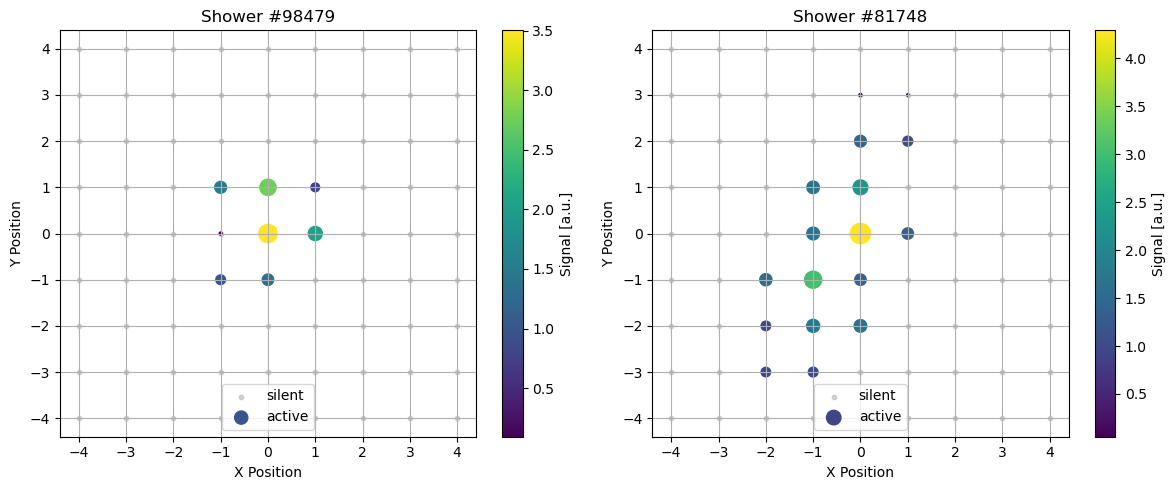

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def rectangular_grid(n=9):
    """Return x, y coordinates for an n x n rectangular detector array centered at 0."""
    half = (n - 1) / 2
    return np.mgrid[0:n, 0:n].astype(float) - half

def plot_air_shower_map(shower, ax, title=None):
    """
    Plot a 9x9 air shower footprint with:
    - all stations (gray)
    - active stations (colored by signal)
    """
    x, y = rectangular_grid(n=9)
    mask = shower > 0
    shower[4, 4] = max(shower[4, 4], 0.01)  # ensure central station is visible

    ax.scatter(x, y, color="gray", s=10, alpha=0.3, label="silent")
    scatter = ax.scatter(
        x[mask], y[mask],
        c=shower[mask],
        s=50 * shower[mask],
        cmap="viridis",
        alpha=1.0,
        label="active"
    )
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Signal [a.u.]")
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.grid(True)
    if title:
        ax.set_title(title)
    ax.legend()

def visualize_generated_showers_styled(G, latent_dim, num_samples=2, device="cpu"):
    G.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        fake_maps = G(z).cpu().squeeze(1).numpy()  # shape: (N, 9, 9)

    fig, axes = plt.subplots(1, num_samples, figsize=(6 * num_samples, 5))
    if num_samples == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        plot_air_shower_map(fake_maps[i], ax, title=f"Shower #{np.random.randint(1e5)}")

    plt.tight_layout()

visualize_generated_showers_styled(G, latent_dim=128, num_samples=2, device=device)

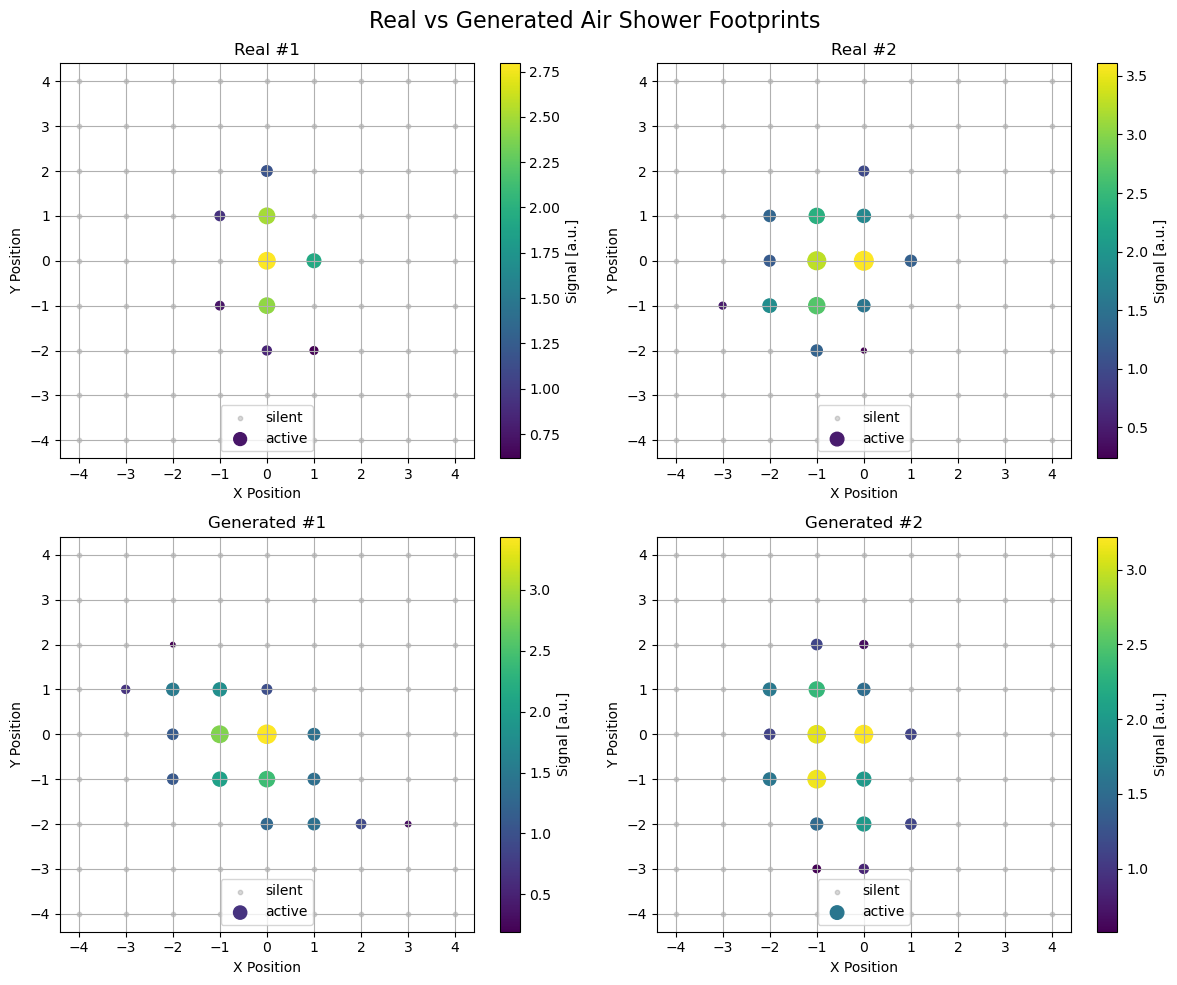

In [57]:
def compare_real_vs_generated_styled(G, real_tensor, latent_dim, device="cpu", num_samples=4):
    """
    Plot real vs. generated air shower maps side-by-side using the same styled layout.
    """
    G.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        fake_maps = G(z).cpu().squeeze(1).numpy()     # (N, 9, 9)
        real_maps = real_tensor[:num_samples].squeeze(1).numpy()  # (N, 9, 9)

    def rectangular_grid(n=9):
        half = (n - 1) / 2
        return np.mgrid[0:n, 0:n].astype(float) - half

    def plot_air_shower(shower, ax, title):
        x, y = rectangular_grid()
        mask = shower > 0
        shower[4, 4] = max(shower[4, 4], 0.01)  # ensure center visibility
        ax.scatter(x, y, color="gray", s=10, alpha=0.3, label="silent")
        scatter = ax.scatter(
            x[mask], y[mask],
            c=shower[mask],
            s=50 * shower[mask],
            cmap="viridis",
            alpha=1.0,
            label="active"
        )
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Signal [a.u.]")
        ax.set_xlabel("X Position")
        ax.set_ylabel("Y Position")
        ax.set_title(title)
        ax.grid(True)
        ax.legend()

    fig, axes = plt.subplots(2, num_samples, figsize=(6 * num_samples, 10))

    for i in range(num_samples):
        plot_air_shower(real_maps[i], axes[0, i], title=f"Real #{i+1}")
        plot_air_shower(fake_maps[i], axes[1, i], title=f"Generated #{i+1}")

    plt.suptitle("Real vs Generated Air Shower Footprints", fontsize=16)
    plt.tight_layout()

compare_real_vs_generated_styled(G, tensor_data, latent_dim=128, device=device, num_samples=2)